# Personal Project -- Classification model to predict heart disease

## 1. Introduction
Heart disease is a common term that encompasses several types of cardiovascular conditions; all of which can often lead to death. The occurrence of heart disease is widespread throughout the world which makes it the number 1 cause of death globally (Lopez, 2023). Thus, it is important for those who may be experiencing symptoms to gain foresight on whether they have heart disease so they can take the necessary health measures. To try and provide such foresight to individuals I aim to answer the question: can we use health measurements (age, resting blood pressure, and serum cholesterol) from patients with a known diagnosis of heart disease, to predict whether future undiagnosed patients have heart disease? To answer this question, the Cleveland dataset, taken from the UCI Heart Disease database, will be used. The dataset includes the measurements of patients from medical procedures, some diagnosed with heart disease and some that did not have heart disease. There are 14 variables, including the diagnosis, and 303 observations (patients).

The relevant variables to this model are described below:
- `age` - The age of the patient (years)
- `trestbps` - resting blood pressure of the patient (mm Hg)
- `chol` - serum cholesterol of the patient (mg/dl)
- `num` - diagnosis of heart disease (0 meaning no heart disease, 1-4 meaning heart disease; `num` will be renamed to `target`)

## 2. Methods & Results

Previous research in the indicators of heart disease has suggested that age, blood pressure, and serum cholesterol are associated with the occurrence of heart disease (Fuchs & Whelton, 2020; Jurgens et al., 2022; Szatrowski et al., 1984). As such, age, resting blood pressure, and serum cholesterol variables from the dataset will be used as predictor variables to predict the presence of heart disease. Since the target variable is categorical, the k-nearest neighbors (KNN) algorithm will be used to construct a classification model. To visualize the results, misclassified observations will be plotted along with the training data to help understand the circumstances in which the classifier struggle.

Some neccesary libraries for the data analysis are below.

In [2]:
library(tidyverse)
library(repr)
library(tidymodels)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

### 2.1 Preliminary exploratory data analysis

The dataset can be read into R as shown below. It does not come with column names so they will be renamed them according to their description in the UCI Heart Disease database website. In the target column, values 1-4 all refer to the presence of heart disease (0 refers to no heart disease) and so they will be grouped together under a new factor value of 1.

In [3]:
cleveland <- read_csv("https://github.com/Shane-M-1/dsci100_project/raw/main/data/heart_disease/processed.cleveland.data", col_names = FALSE)
colnames(cleveland) <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target")

cleveland <- mutate(cleveland,
                    age = as.integer(age),
                    target = as_factor(target),
             ) |>
            mutate(target = fct_recode(target, "1" = "2", "1" = "3", "1" = "4"))
head(cleveland)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


Before the data is split, only the predictor variables (`age`, `trestbps`, `chol`) and `target` variable will be selected to simplify the dataset. A split of 75% training and 25% testing will be made so that there is enough data to try and train an accurate model since the dataset is not very large. I will then create summary tables containing the proportions of each factor value of `target` and the means and max values of the predictors.

In [4]:
cleveland_select <- cleveland |>
    select(age, trestbps, chol, target)

set.seed(1)

cleveland_split <- initial_split(cleveland_select, prop = 0.75, strata = target)
cleveland_training <- training(cleveland_split)
cleveland_testing <- testing(cleveland_split)

num_obs <- nrow(cleveland_training) 

cleveland_training |>
    group_by(target) |>
    summarize(
        count = n(),
        percentage = n() / num_obs * 100
    )

target,count,percentage
<fct>,<int>,<dbl>
0,123,54.18502
1,104,45.81498


<span style="color:gray">Figure 1</span>

In [6]:
# table for means
select(cleveland_training, age:chol) |>
    summarize(mean_age = mean(age),
              mean_trestbps = mean(trestbps),
              mean_chol = mean(chol)
              )

mean_age,mean_trestbps,mean_chol
<dbl>,<dbl>,<dbl>
54.9207,132.7709,246.9604


<span style="color:gray">Figure 2</span>

In [8]:
# table for max values
select(cleveland_training, age:chol) |>
    summarize(max_age = max(age),
              max_trestbps = max(trestbps),
              max_chol = max(chol)
              )

max_age,max_trestbps,max_chol
<int>,<dbl>,<dbl>
77,180,417


<span style="color:gray">Figure 3</span>

From the tables above, we see that in the training data there are 123 (54%) observations without heart disease, and 104 (46%) heart-diseased observations. We also see that the mean age is ~55 years old, mean resting blood pressure is ~133 mm Hg, and mean cholesterol is ~247 mg/dl. We see the max values for age, resting blood pressure, and cholesterol are 77, 180, and 417, respectively. The last two tables give a sense of the range and center of each of the predictors; since the range and center of the predictors are all different I will have to scale and center them as a preprocessing step when I create the model.

Below, I will generate plots to visualize any association with the predictors and target variable.

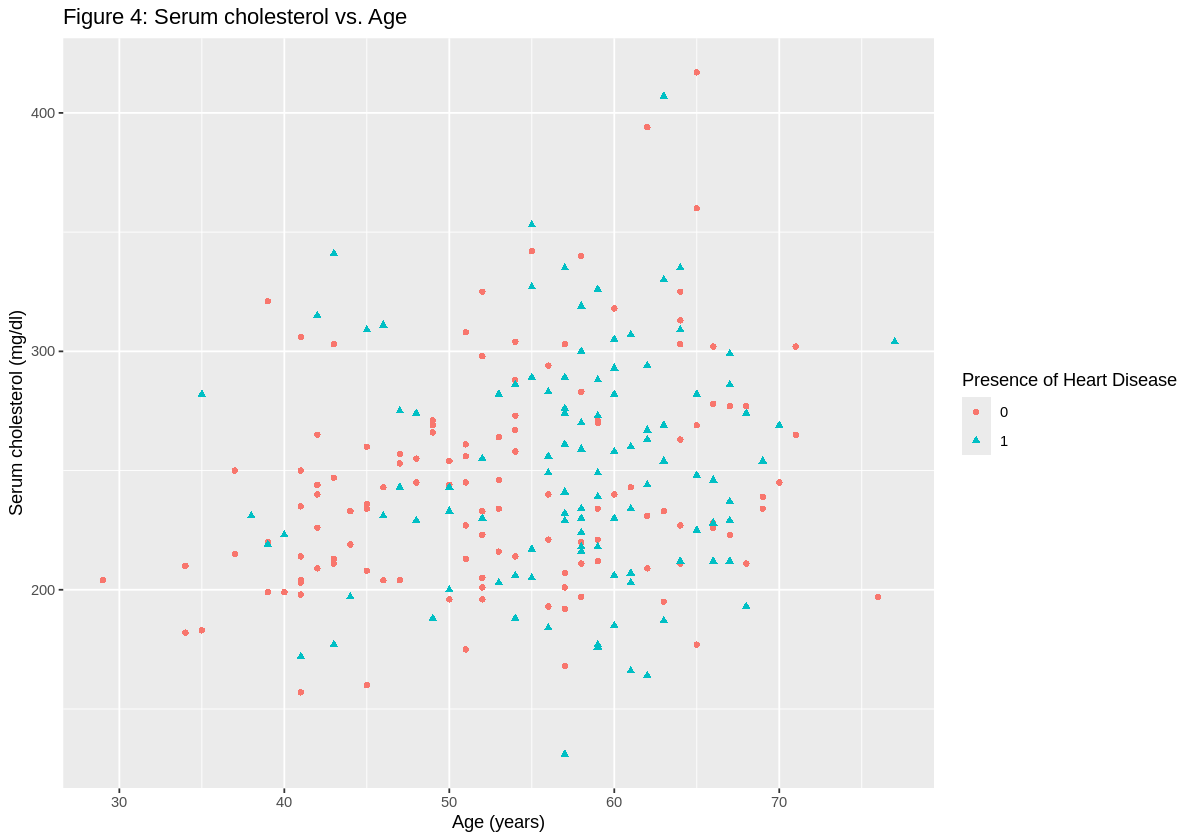

In [12]:
options(repr.plot.width = 10, repr.plot.height = 7)
ggplot(cleveland_training, aes(x = age, y = chol, color = target, shape = target)) +
    geom_point() +
    labs(
        x = "Age (years)",
        y = "Serum cholesterol (mg/dl)",
        color = "Presence of Heart Disease",
        shape = "Presence of Heart Disease"
    ) +
    ggtitle("Figure 4: Serum cholesterol vs. Age")

From the scatterplot, we see that there is no obvious correlation between two of the proposed predictor variables and heart disease. Let's look at the distribution of the predictors across each target value.

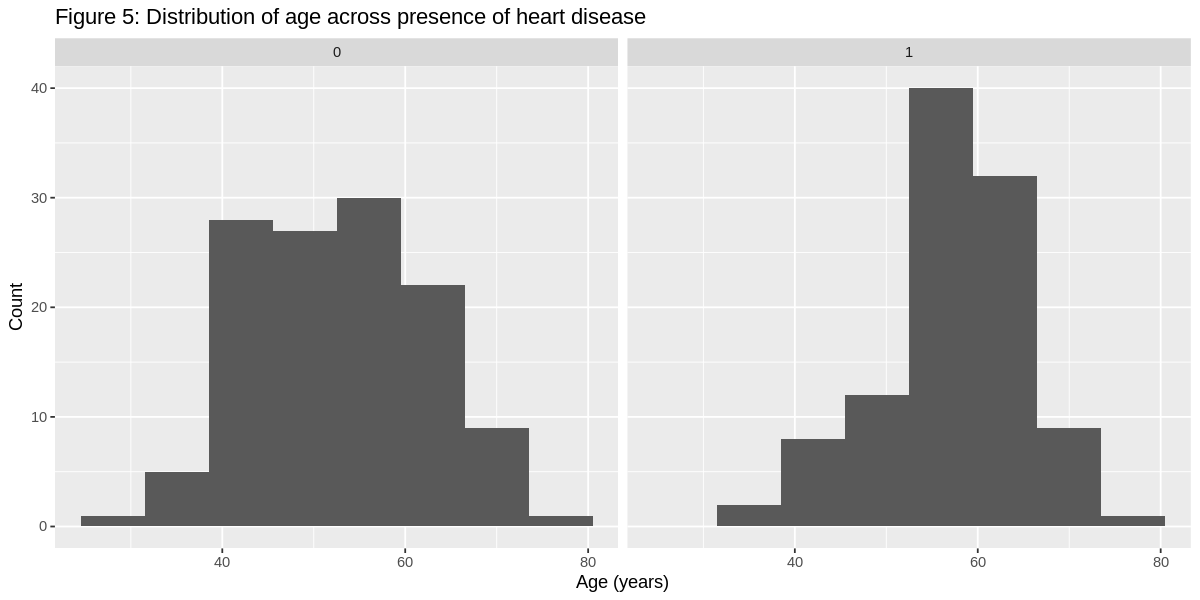

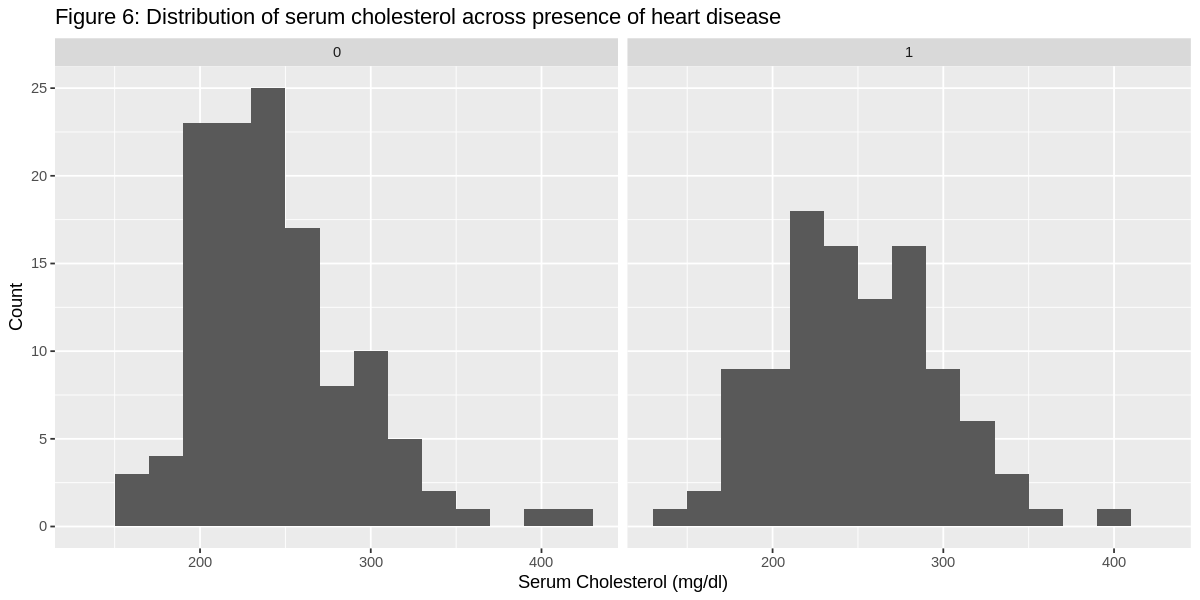

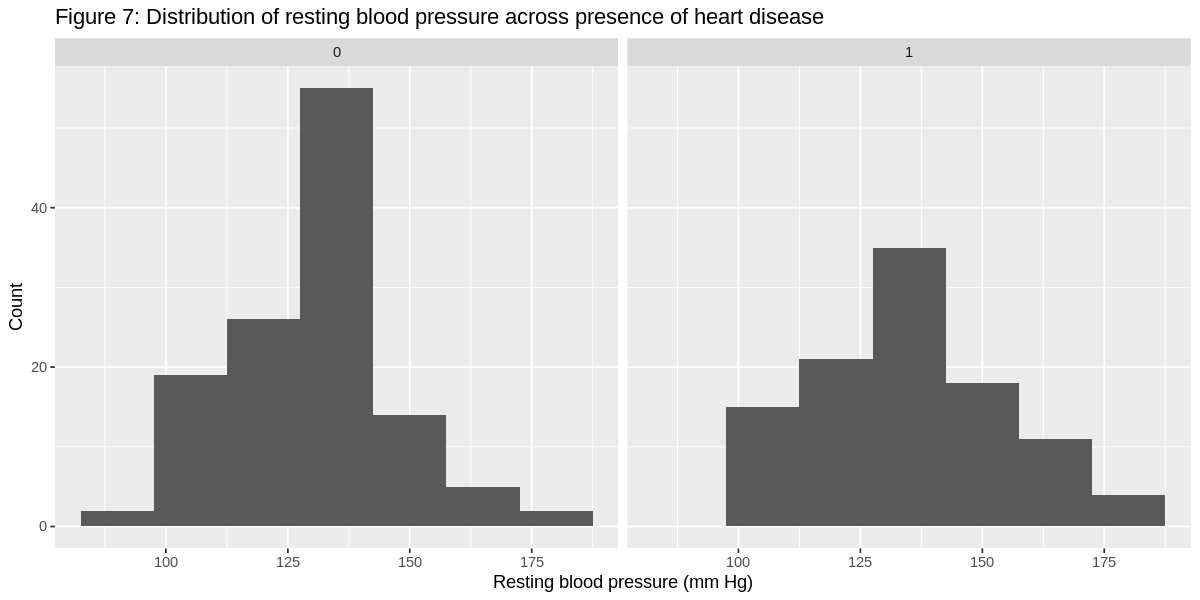

In [13]:
options(repr.plot.width = 10, repr.plot.height = 5)
cleveland_hist1 <- ggplot(cleveland_training, aes(x = age)) +
    geom_histogram(position = "dodge", binwidth = 7) +
    facet_wrap(vars(target)) +
    xlab("Age (years)") +
    ylab("Count") + 
    ggtitle("Figure 5: Distribution of age across presence of heart disease")

cleveland_hist2 <- ggplot(cleveland_training, aes(x = chol)) +
    geom_histogram(position = "dodge", binwidth = 20) +
    facet_wrap(vars(target)) +
    xlab("Serum Cholesterol (mg/dl)") +
    ylab("Count") + 
    ggtitle("Figure 6: Distribution of serum cholesterol across presence of heart disease")

cleveland_hist3 <- ggplot(cleveland_training, aes(x = trestbps)) +
    geom_histogram(position = "dodge", binwidth = 15) +
    facet_wrap(vars(target)) +
    xlab("Resting blood pressure (mm Hg)") +
    ylab("Count") + 
    ggtitle("Figure 7: Distribution of resting blood pressure across presence of heart disease")

cleveland_hist1
cleveland_hist2
cleveland_hist3

In the histograms, we also see that the distributions of each of the predictor variables show no obvious patterns. It is important to note that these plots do not necessarily disqualify these variables to be used as predictors because while they may not suggest a correlation with heart disease on their own, the use of all predictors together could be beneficial. This is what will be investigated when the classification model is created and tested.

### 2.2 Model construction

Before a k-nearest neighbors classification model can be made I will have to select a value for $K$. I will use R to choose an appropriate value for $K$ by performing 5-fold cross-validation in the training set. Also, it was established earlier that the predictor variables are of different centers and ranges and so I will need to preprocess them (scale and center) to ensure each variable contributes equally when computing distances between points.

In [15]:
set.seed(1)

knn_init_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_recipe <- recipe(target ~ ., data = cleveland_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

cleveland_vfold <- vfold_cv(cleveland_training, v = 5, strata = target)

nums <- tibble(neighbors = seq(from = 1, to = 50, by = 4))

cleveland_k <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_init_spec) |>
    tune_grid(resamples = cleveland_vfold, grid = nums) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean)) |>
    slice(1) |>
    pull(neighbors)
cleveland_k

[1] 37

Now that a $K$ has been chosen, the actual model can be created. 

In [16]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = cleveland_k) |>
    set_engine("kknn") |>
    set_mode("classification")

cleveland_fit <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_spec) |>
    fit(data = cleveland_training)

The KNN model has been constructed. We can now use it to predict on the testing set.

In [17]:
cleveland_predictions <- predict(cleveland_fit, cleveland_testing) |>
    bind_cols(cleveland_testing) 

### 2.3 Results

The model has predicted on the testing set so we can now view its performance through a few tables and visualizations. Each figure will be discussed in the **Discussion**. First I will collect the accuracy and generate a confusion matrix.

In [18]:
cleveland_metrics <- cleveland_predictions |>
    metrics(truth = target, estimate = .pred_class) |>
    filter(.metric == 'accuracy')

cleveland_conf_mat <- cleveland_predictions |>
    conf_mat(truth = target, estimate = .pred_class)

In [20]:
cleveland_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6447368


<span style="color:gray">Figure 8</span>

In [21]:
cleveland_conf_mat

          Truth
Prediction  0  1
         0 30 16
         1 11 19

<span style="color:gray">Figure 9</span>

I will also create scatterplots containing the misclassified observations along with the training set with each pair of predictors, as mentioned earlier.

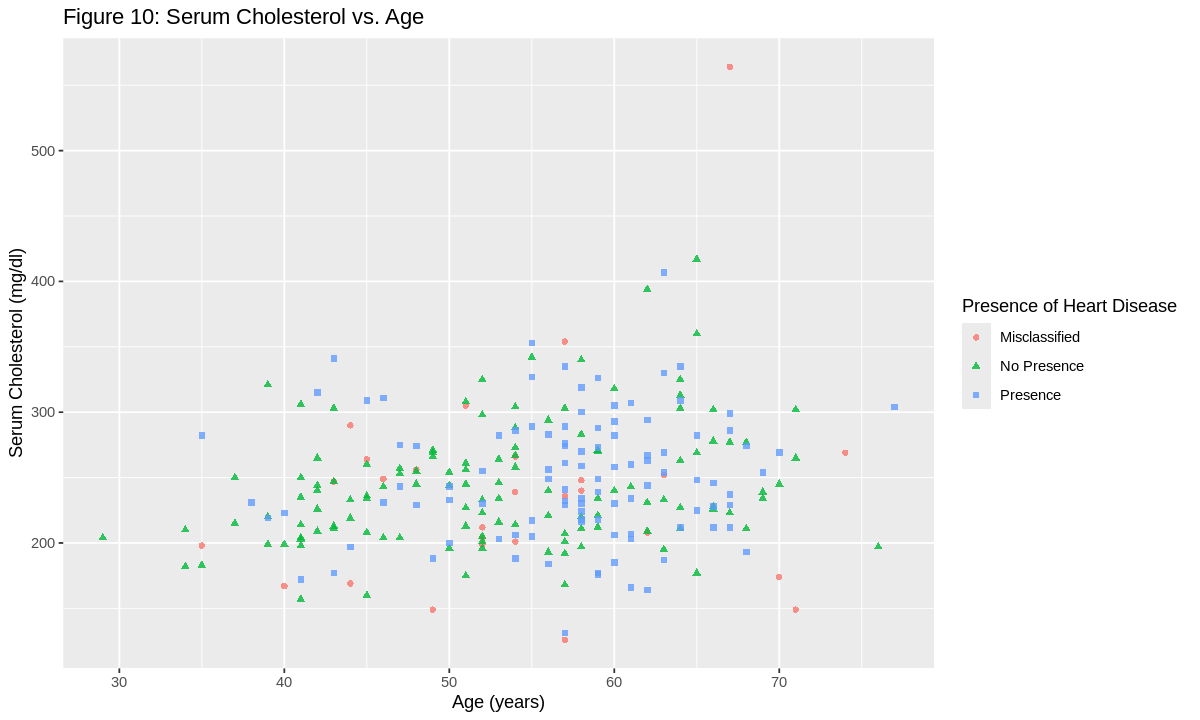

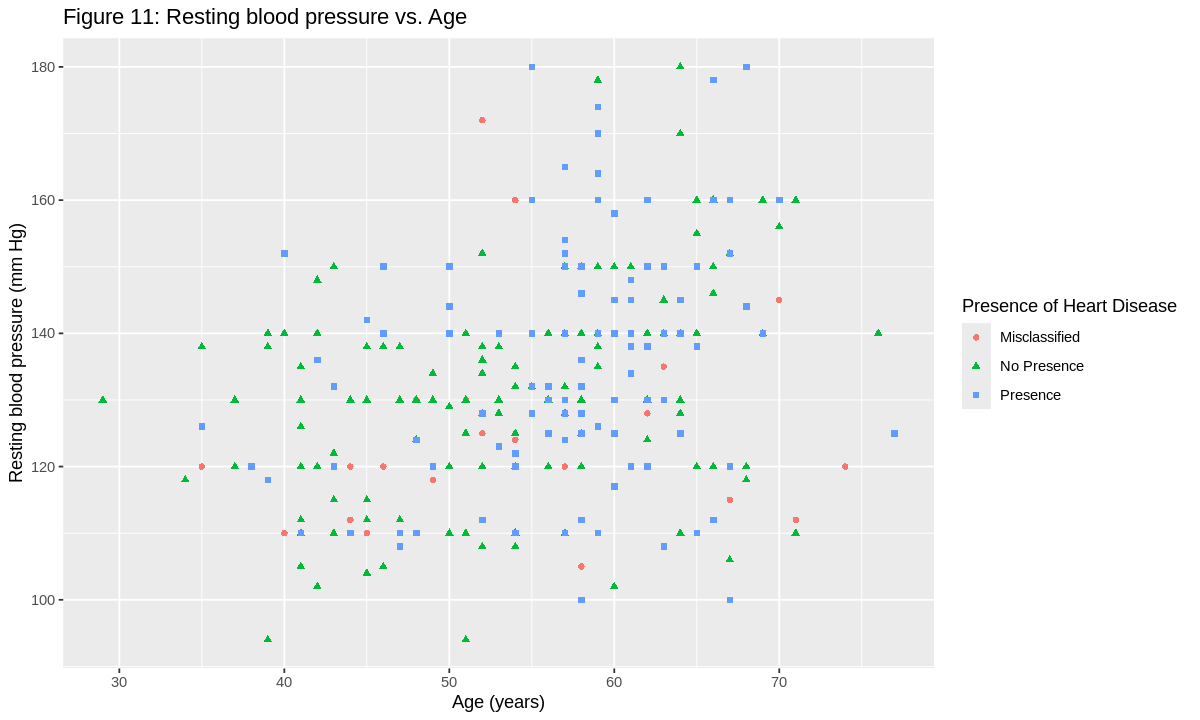

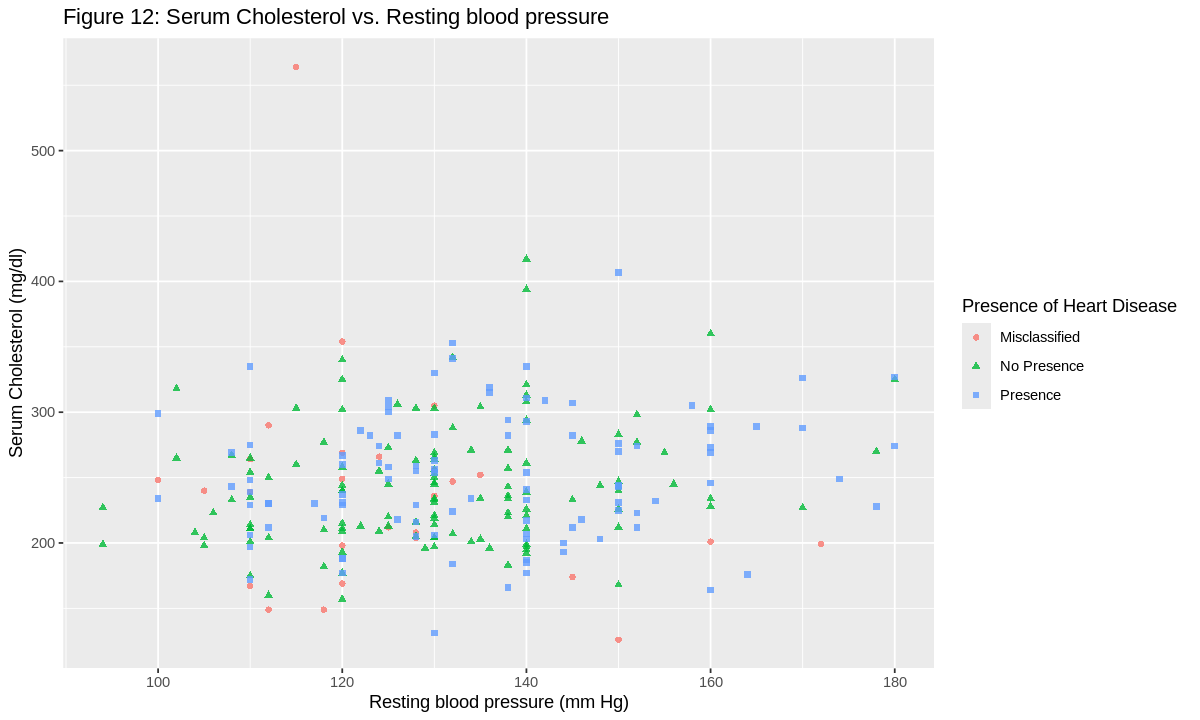

In [23]:
options(repr.plot.width = 10, repr.plot.height = 6)

misclassified <- cleveland_predictions |>
    filter(target != .pred_class) |>
    mutate(target = fct_recode(target, "2" = "0", "2" = "1"))

mixed_cleveland <- bind_rows(misclassified, cleveland_training)

mixed_plot <- ggplot(mixed_cleveland, aes(x = age, y = chol, color = target, shape = target)) +
    geom_point(alpha = 0.8) +
    labs(x = "Age (years)", y = "Serum Cholesterol (mg/dl)", 
         title = "Figure 10: Serum Cholesterol vs. Age", color = "Presence of Heart Disease", shape = "Presence of Heart Disease") +
    scale_color_hue(labels = c("Misclassified", "No Presence", "Presence")) + 
    scale_shape_discrete(labels = c("Misclassified", "No Presence", "Presence"))  
mixed_plot

mixed_plot2 <- ggplot(mixed_cleveland, aes(x = age, y = trestbps, color = target, shape = target)) +
    geom_point() +
    labs(x = "Age (years)", y = "Resting blood pressure (mm Hg)", 
         title = "Figure 11: Resting blood pressure vs. Age", color = "Presence of Heart Disease", shape = "Presence of Heart Disease") +
    scale_color_hue(labels = c("Misclassified", "No Presence", "Presence")) + 
    scale_shape_discrete(labels = c("Misclassified", "No Presence", "Presence"))
mixed_plot2

mixed_plot3 <- ggplot(mixed_cleveland, aes(x = trestbps, y = chol, color = target, shape = target)) +
    geom_point(alpha = 0.8) +
    labs(x = "Resting blood pressure (mm Hg)", y = "Serum Cholesterol (mg/dl)", 
         title = "Figure 12: Serum Cholesterol vs. Resting blood pressure", color = "Presence of Heart Disease", shape = "Presence of Heart Disease") +
    scale_color_hue(labels = c("Misclassified", "No Presence", "Presence")) + 
    scale_shape_discrete(labels = c("Misclassified", "No Presence", "Presence"))
mixed_plot3

I will also collect the precision and recall of our classifier. An observation having heart disease is the more interesting factor value of `target` and will thus be considered the positive label. First I need to check the order of levels of `target`.

In [24]:
cleveland_predictions |> pull(target) |> levels()

[1] "0" "1"

Hence, the positive label is the second level.

In [54]:
cleveland_precision <- precision(cleveland_predictions, truth = target, estimate = .pred_class, event_level = "second") |>
    pull(.estimate)

cleveland_recall <- recall(cleveland_predictions, truth = target, estimate = .pred_class, event_level = "second") |>
    pull(.estimate)

tibble(precision = c(cleveland_precision), recall = c(cleveland_recall))

precision,recall
<dbl>,<dbl>
0.6333333,0.5428571


<span style="color:gray">Figure 13</span>

## 3. Discussion

### 3.1 Summary

The research question driving the construction of this classification model was whether we can predict if undiagnosed patients have heart disease, given their age, serum cholesterol, and resting blood pressure. A k-nearest neighbors classification model with $K = 37$ (chosen from cross-validation) was created to answer this question. From Figure 8, the recorded accuracy from the KNN classification model's performance on the testing set was 64%. From Figure 13, the precision and recall were 63% and 54%, respectively. Each of the recorded measurements indicates a poor performance by the model. Although this model's accuracy is better than a majority classifier based on this dataset -- which would have an accuracy of around 54% according to Figure 1 -- the accuracy is still very low when contextualized in its possible applications in medical settings. Figures 10-12 show that the misclassified observations appear to be randomly scattered throughout the data; there are no obvious circumstances that can be identified within the plots that suggest where the classifier goes wrong. The confusion matrix (Figure 9) shows the classifier is best at classifying observations with no heart disease (but still often misclassifies these observations), and is poor at classifying heart-diseased observations. 

###  3.2 Is this what you expected to find?

The literature used to select the predictors suggested that each of them are indeed indicators of heart disease. Hence, I expected a better performance from the classifier than what was found. Upon researching reasons for the classifier's poor performance, literature regarding heart disease indicates that a heart disease diagnosis requires more than just a few medical readings; factors like family history, obesity, exercise tolerance, and many more measurements are considered in a heart disease diagnosis (Lopez, 2023). With this information, it would make sense why the classifier I had created had such low metrics, since the classifier only used 3 predictors.

### 3.3 What impact could your findings have?

As previously discussed, the KNN classification model performed poorly which could have been expected when considering the many indicators used to diagnose heart disease according to the earlier mentioned literature. Thus, these findings suggest that a heart disease classifier requires more than just age, serum cholesterol, and resting blood pressure as predictor variables; the results of this model should urge others who are looking to create a model to predict heart disease, to use either use more predictors or try different predictors in their model. The findings of this report also affirm that a classification model using only age, serum cholesterol, and resting blood pressure is not appropriate for practical applications. An accuracy of 64% is far too low to be reliably used to diagnose patients. A recall of 54% in a real medical setting would be very dangerous since it would mean 46% of truly heart-diseased patients would receive the wrong diagnosis. 

### 3.4 What future questions could this lead to?

As discussed in the previous subsection, the findings of this report may inspire the construction of similar classifiers to predict heart disease, but with different or more predictors. Naturally, this leads to the question of which predictors are missing from this classifier and how many more are needed? 

## 4. References

- Fuchs, F. D., & Whelton, P. K. (2020). High blood pressure and cardiovascular disease. Hypertension, 75(2), 285–292. https://doi.org/10.1161/hypertensionaha.119.14240 

- Janosi, A., Steinbrunn, W., Pfisterer, M., & Detrano, R. (1988, June 30). Cleveland Heart Disease, UC Irvine Machine Learning Repository. https://archive.ics.uci.edu/dataset/45/heart+disease

- Jurgens, C. Y., Lee, C. S., Aycock, D. M., Masterson Creber, R., Denfeld, Q. E., DeVon, H. A., Evers, L. R., Jung, M., Pucciarelli, G., Streur, M. M., & Konstam, M. A. (2022). State of the science: The relevance of symptoms in cardiovascular disease and research: A scientific statement from the American Heart Association. Circulation, 146(12). https://doi.org/10.1161/cir.0000000000001089 

- Lopez, E. O. (2023, August 22). Cardiovascular disease. StatPearls [Internet]. https://www.ncbi.nlm.nih.gov/books/NBK535419/ 

- Szatrowski, T. P., Peterson, A. V., Shimizu, Y., Prentice, R. L., Mason, M. W., Fukunaga, Y., & Kato, H. (1984). Serum cholesterol, other risk factors, and cardiovascular disease in a Japanese cohort. Journal of Chronic Diseases, 37(7), 569–584. https://doi.org/10.1016/0021-9681(84)90007-9 